# 1. detect people

In [1]:
# based on: https://www.youtube.com/watch?v=Pb3opEFP94U&t=813s
# based on: https://colab.research.google.com/drive/1x-eMvFQTLBTr7ho9ZlYkHF0NmyUyAlxT?usp=sharing#scrollTo=Z_pe5XFayoHP

### import libraries

In [132]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2 import model_zoo
from detectron2.structures import Boxes
from detectron2.structures import Keypoints
from PIL import Image
from SVM import *

import detectron2
import cv2 as cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import timeit
import pandas as pd
import random as rnd

### configure detector

In [133]:
def __init__(mode):
    """
    Method initializing a detector with a config file

    :param: mode: Select work mode (Object Detection, Keypoint Extraction)

    :return predictor and cfg objects
    """

    if mode == "OD":
        cfg_od = get_cfg()
        cfg_od.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
        cfg_od.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

        cfg_od.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
        cfg_od.MODEL.DEVICE = "cpu"
        predictor_od = DefaultPredictor(cfg_od)

        return predictor_od, cfg_od

    elif mode == "KP":
        cfg_kp = get_cfg()
        cfg_kp.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
        cfg_kp.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

        cfg_kp.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
        cfg_kp.MODEL.DEVICE = "cpu"
        predictor_kp = DefaultPredictor(cfg_kp)

        return predictor_kp, cfg_kp

predictor_od, cfg_od = __init__(mode="OD")

### define function responsible for detected class reduction to one

In [134]:
def chooseOneClassFromAllDetected(initialPredictions, image):
    """
    Method responsible for reducing detected object classes to one particular

    :param: initialPredictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)
    :param: image: image to be processed
    """

    classes = initialPredictions["instances"].pred_classes
    scores = initialPredictions["instances"].scores
    boxes = initialPredictions["instances"].pred_boxes

    index_to_keep = (classes == 0).nonzero().flatten().tolist()

    classes_filtered = torch.tensor(np.take(classes.cpu().numpy(), index_to_keep))
    scores_filtered = torch.tensor(np.take(scores.cpu().numpy(), index_to_keep))
    boxes_filtered = Boxes(
        torch.tensor(np.take(boxes.tensor.cpu().numpy(), index_to_keep, axis=0))
    )

    obj = detectron2.structures.Instances(
        image_size=(image.shape[0], image.shape[1])
    )
    obj.set("pred_classes", classes_filtered)
    obj.set("scores", scores_filtered)
    obj.set("pred_boxes", boxes_filtered)

    return obj

### load an image

In [177]:
def loadImage(imagePath, changeColorMode=True):
    """
    Method responsible for loading an image

    :param: imagePath: path to the image
    :param: changeColorMode: change BGR to RGB, useful when using both cv2 and matplotlib

    :return image object
    """

    image = cv2.imread(imagePath)
    if changeColorMode == True:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

image = loadImage(imagePath="images/cross_walk_she.png", changeColorMode=True)

### perform detection and make prediction boxes

In [178]:
def performDetection(predictor, image, classReduction):
    """
    Method performing actual detection

    :param: predictor: predictor object
    :param: image: image object
    :param: classReduction: enables class reduction to one


    :return prediction, (optionally) new_predictions and prediction boxes objects
    """

    predictions = predictor(image)

    if classReduction == True:
        new_predictions = chooseOneClassFromAllDetected(initialPredictions=predictions, image=image)
        prediction_boxes = [x.numpy() for x in list(new_predictions.pred_boxes)]

        return predictions, new_predictions, prediction_boxes

    elif classReduction == False:

        return predictions

predictions_od, new_predictions_od, prediction_od_boxes = performDetection(predictor=predictor_od, image=image, classReduction=True)

### make visualization part and extract image with boxes

In [179]:
viz_od = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
output_od = viz_od.draw_instance_predictions(new_predictions_od.to("cpu"))

image_with_boxes = output_od.get_image()[:, :, ::-1]

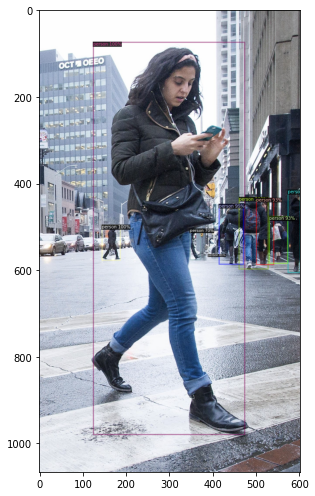

In [180]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(image_with_boxes)
plt.tight_layout()

# 2. cut part of the image from bounding boxes

In [181]:
# based on: https://stackoverflow.com/questions/68008935/crop-image-using-pred-boxes-coordinates

### define function responsible for cropping part of an image defined by bounding box coordinates

In [182]:
def cropImageByBoundingBox(image, box):
    """
    Function responsible for cropping part of an image defined by bounding box coordinates

    :param: image: image to be processed
    :param: box: numpy array with four box coordinates

    return: cropped image object
    """

    x_top_left = box[0]
    y_top_left = box[1]
    x_bottom_right = box[2]
    y_bottom_right = box[3]

    if type(image) == np.ndarray:
        image = Image.fromarray(image)
    crop_img = image.crop((int(x_top_left), int(y_top_left), int(x_bottom_right), int(y_bottom_right)))

    if type(image) == Image.Image:
        crop_img = np.array(crop_img)

    return crop_img, (x_top_left, y_top_left)

### perform exemplary cropping

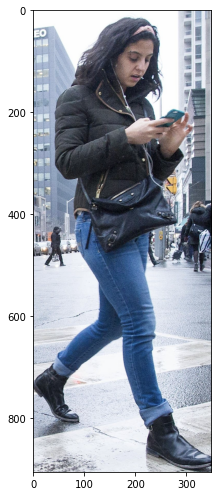

In [183]:
image_index = 0
image_cropped, cropped_image_coordinates = cropImageByBoundingBox(image, prediction_od_boxes[image_index])

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(image_cropped)
plt.tight_layout()

# 3. make individual skeletonization for each cropped image

### configure another detector (keypoint extraction)

In [184]:
predictor_kp, cfg_kp = __init__(mode="KP")

### make predictions

In [185]:
predictions_kp = performDetection(predictor=predictor_kp, image=image_cropped, classReduction=False)

/Users/michal/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


### define function to filter detections to take only the best one

In [186]:
def chooseIndexOfBestKeypointInstanceFromAllDetected(predictions):
    """
    Method responsible for choosing the best (the longest in the sense of euclidean distance) detection instance

    :param: predictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)

    return index of the best (the longest in the sense of euclidean distance) prediction
    """

    # index = np.array([predictions["instances"][i].pred_keypoints.numpy().sum() for i in range(len(predictions["instances"].pred_keypoints.numpy()))])

    length = len(predictions["instances"].pred_keypoints.numpy())
    [predictions["instances"][i].pred_keypoints.numpy().sum() for i in range(length)]

    initial_predictions_all = predictions["instances"].pred_keypoints.numpy()
    index = np.array([])

    for prediction in initial_predictions_all:
        sum = 0
        for i in range(len(prediction)-1):
            sum += np.linalg.norm(prediction[i] - prediction[i+1])
        index = np.append(index, sum)

    if len(index) > 0:
        index_of_value_to_keep = np.argmax(index)
    else:
        index_of_value_to_keep = 0

    return int(index_of_value_to_keep)

### visualize results

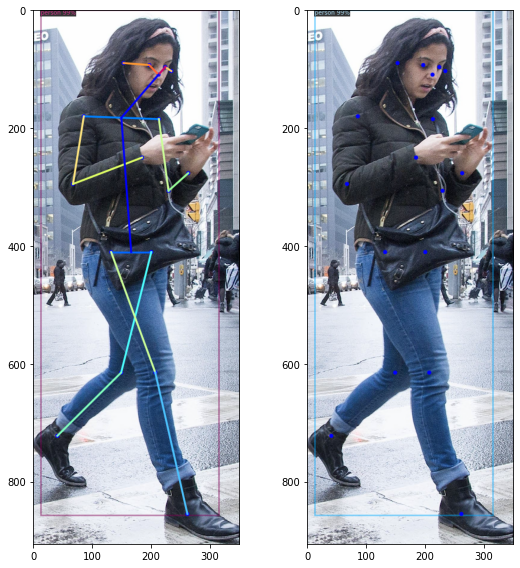

In [187]:
viz_kp = Visualizer(image_cropped[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
viz_kp_dots = Visualizer(image_cropped[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
if index == 0:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
    output_kp_dots = viz_kp_dots.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
else:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
    output_kp_dots = viz_kp_dots.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
image_skeletonized = output_kp.get_image()[:, :, ::-1]
image_skeletonized_dots = output_kp_dots.get_image()[:, :, ::-1]

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(image_skeletonized)
ax[1].imshow(image_skeletonized_dots)
plt.tight_layout()

In [188]:
# it seems that detecting people and making skeletons on a scene image (the initial one) gives better accuracy skeletonization
# compared to detecting people and making skeletonization on individual people

# 4. project individual masks on the initial picture

### projecion without coordinates correction

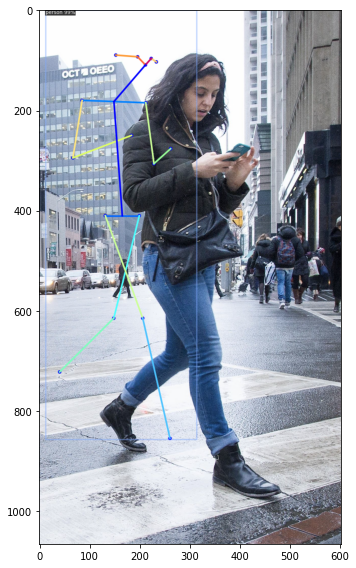

In [189]:
viz_kp = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
if index == 0:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
else:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
image_skeletonized = output_kp.get_image()[:, :, ::-1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_skeletonized)
plt.tight_layout()

### projecion with coordinates correction

In [190]:
def correctIndividualSkeletonCoordinates(initialPredictions, image, croppedImageCoordinates):
    """
    Method responsible for correction of individual detection (box, keypoints) coordinates to match initial picture position

    :param: initialPredictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)
    :param: image: cropped image
    :param: croppedImageCoordinates: cooridnates of the cropped image on the initiial one

    return corrected predictions (box, keypoints)
    """

    boxes = initialPredictions["instances"].pred_boxes
    boxes_filtered = boxes.tensor.cpu().numpy().copy()
    boxes_filtered[:,0] += croppedImageCoordinates[0]
    boxes_filtered[:,2] += croppedImageCoordinates[0]
    boxes_filtered[:,1] += croppedImageCoordinates[1]
    boxes_filtered[:,3] += croppedImageCoordinates[1]

    keypoints = initialPredictions["instances"].pred_keypoints
    keypoints_filtered = keypoints.cpu().numpy().copy()
    keypoints_filtered[:,:,0] += croppedImageCoordinates[0]
    keypoints_filtered[:,:,1] += croppedImageCoordinates[1]

    scores = initialPredictions["instances"].scores

    boxes_filtered = Boxes(torch.tensor(boxes_filtered))
    keypoints_filtered = torch.tensor(keypoints_filtered)

    obj = detectron2.structures.Instances(image_size=(image.shape[0], image.shape[1]))
    obj.set("pred_boxes", boxes_filtered)
    obj.set("pred_keypoints", keypoints_filtered)
    obj.set("scores", scores)

    return obj

In [191]:
new_preds = correctIndividualSkeletonCoordinates(initialPredictions=predictions_kp, image=image_cropped, croppedImageCoordinates=cropped_image_coordinates)

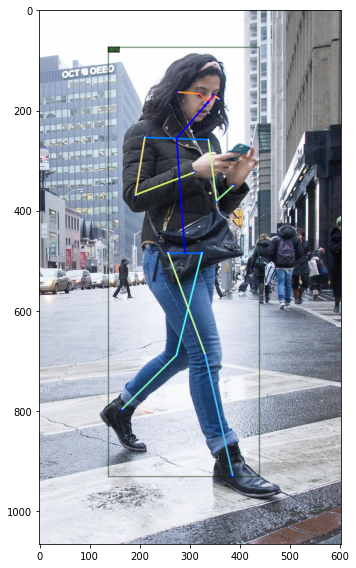

In [192]:
viz_kp = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)

if index == 0:
    output_kp = viz_kp.draw_instance_predictions(new_preds.to("cpu"))
else:
    output_kp = viz_kp.draw_instance_predictions(new_preds[index].to("cpu"))
image_skeletonized = output_kp.get_image()[:, :, ::-1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_skeletonized)
plt.tight_layout()

In [193]:
def combineAllPredictionsTogether(predictionsDict):
    """
    Method responsible for combining all predictions from individual images into one

    :param: predictionsDict: dictionary with predictions for each image

    return one combined prediction instance object
    """

    number_of_people = len(predictionsDict.keys())
    pred_sum = predictionsDict[0]
    boxes_sum = pred_sum.pred_boxes.tensor.cpu().numpy().copy()
    keypoints_sum = pred_sum.pred_keypoints.cpu().numpy().copy()
    scores_sum = pred_sum.scores.cpu().numpy().copy()

    if number_of_people > 1:
        for i in range(1, number_of_people-1):
            pred = predictionsDict[i]
            boxes = pred.pred_boxes.tensor.cpu().numpy().copy()
            keypoints = pred.pred_keypoints.cpu().numpy().copy()
            scores = pred.scores.cpu().numpy().copy()

            boxes_sum = np.vstack([boxes_sum, boxes])
            keypoints_sum = np.vstack([keypoints_sum, keypoints])
            scores_sum = np.append(scores_sum, scores)

    boxes_sum = Boxes(torch.tensor(boxes_sum))
    keypoints_sum = torch.tensor(keypoints_sum)

    obj = detectron2.structures.Instances(image_size=(image.shape[0], image.shape[1]))
    obj.set("pred_boxes", boxes_sum)
    obj.set("pred_keypoints", keypoints_sum)
    obj.set("scores", scores_sum)

    return obj

# put steps 1-4 together

/Users/michal/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


Execution time was: 74.95757129200501  s


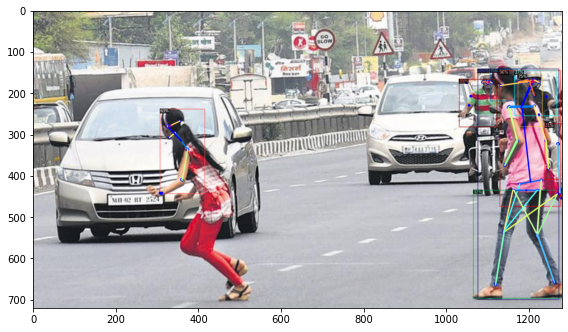

In [218]:
start_time = timeit.default_timer()

# prepare detectors
## initialize OD detector
predictor_od, cfg_od = __init__(mode="OD")

## initialize KP detector
predictor_kp, cfg_kp = __init__(mode="KP")

# 0. load an image
imagePath = "images/Pedestrian-Deaths-India-Road-Fatalities-India-1280x720.jpeg"
image = loadImage(imagePath=imagePath, changeColorMode=True)

# 1. perform detection and make prediction boxes
(
    predictions_od,
    reduced_predictions_od,
    prediction_od_boxes,
) = performDetection(
    predictor=predictor_od, image=image, classReduction=True
)
## make visualization part
viz_od = Visualizer(
    image[:, :, ::-1],
    metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]),
    instance_mode=ColorMode.IMAGE,
)
output_od = viz_od.draw_instance_predictions(reduced_predictions_od.to("cpu"))
image_with_boxes = output_od.get_image()[:, :, ::-1]

number_of_people = len(reduced_predictions_od)
predictions_kp_all = {}
images_kp_all = {}
image_final = image.copy()

for person_index in range(number_of_people):
    # 2. cut part of the image from bounding boxes
    image_cropped, cropped_image_coordinates = cropImageByBoundingBox(
        image=image, box=prediction_od_boxes[person_index]
    )

    # 3. make individual skeletonization for the cropped image
    ## perform detection
    predictions_kp = performDetection(
        predictor=predictor_kp, image=image_cropped, classReduction=False
    )
    ## make visualization part
    viz_kp = Visualizer(
        image_cropped[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
    )
    index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
    if index == 0:
        output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
    else:
        output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
    image_skeletonized = output_kp.get_image()[:, :, ::-1]

    # 4. project individual mask on the initial picture
    corrected_predictions = correctIndividualSkeletonCoordinates(
        initialPredictions=predictions_kp,
        image=image_cropped,
        croppedImageCoordinates=cropped_image_coordinates,
    )
    ## make visualization part
    viz_kp = Visualizer(
        image[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
    )
    if index == 0:
        output_kp = viz_kp.draw_instance_predictions(corrected_predictions.to("cpu"))
    else:
        output_kp = viz_kp.draw_instance_predictions(corrected_predictions[index].to("cpu"))
    image_skeletonized = output_kp.get_image()[:, :, ::-1]
    ## combine all results
    if index == 0:
      predictions_kp_all[person_index] = corrected_predictions.to("cpu")
    else:
      predictions_kp_all[person_index] = corrected_predictions[index].to("cpu")

    images_kp_all[person_index] = image_skeletonized

final_predictions = combineAllPredictionsTogether(predictionsDict=predictions_kp_all)
viz_kp = Visualizer(
        image[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
)
output_sum = viz_kp.draw_instance_predictions(final_predictions.to("cpu"))
image_sum = output_sum.get_image()[:, :, ::-1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_sum)
plt.tight_layout()

stop_time = timeit.default_timer()
time_execution_difference = stop_time - start_time
print("Execution time was:", time_execution_difference, " s")

# experiment: detect people all by once and measure time

Execution time was: 15.578792792002787  s


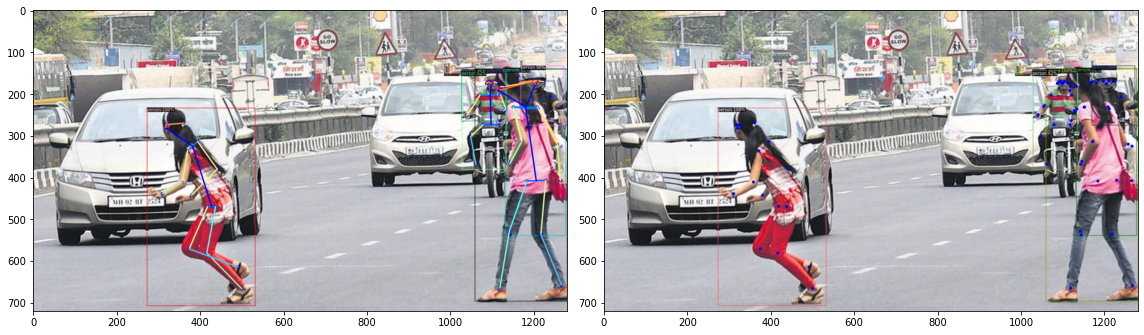

In [219]:
## start measuring execution time
start_time = timeit.default_timer()

## initialize KP detector
predictor_kp, cfg_kp = __init__(mode="KP")

## make predictions
predictions_kp = performDetection(predictor=predictor_kp, image=image, classReduction=False)

## make visualization part
viz_kp = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
viz_kp_dots = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
output_kp_dots = viz_kp_dots.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
image_final = output_kp.get_image()[:, :, ::-1]
image_final_dots = output_kp_dots.get_image()[:, :, ::-1]

## show resulsts
fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].imshow(image_final)
ax[1].imshow(image_final_dots)
plt.tight_layout()

## stop measuring execution time
stop_time = timeit.default_timer()
time_execution_difference = stop_time - start_time
print("Execution time was:", time_execution_difference, " s")

# 5. people classification:
- ## entering the road
- ## being on the road
- ## off the interest scope (on a bike, motorcycle, etc.)

### add picture skeleton data to dataframe for classification

In [220]:
def addPedestrianDataToDataFrame(predictions, index, classification, df=None):
    """
    Method resonsible for creating DataFrame from predictions' keypoints

    :param: predictions: predictions for the whole scene
    :param: index: index of the selected person
    :param: classification: label for the new entry ('stationary', 'in motion')
    :param: df: pandas DataFrame

    return existing df with appended new entry if df is not None and df with new entry only otherwise
    """

    keypoints_x = predictions["instances"][index].pred_keypoints.to("cpu").numpy()[:,:,0]
    keypoints_x_normalized = keypoints_x / np.linalg.norm(keypoints_x)
    keypoints_y = predictions["instances"][index].pred_keypoints.to("cpu").numpy()[:,:,1]
    keypoints_y_normalized = keypoints_y / np.linalg.norm(keypoints_y)
    # keypoints_score = predictions["instances"][index].pred_keypoints.to("cpu").numpy()[:,:,2]

    # keypoint_vector = np.hstack([keypoints_x_normalized, keypoints_y_normalized, keypoints_score])
    keypoint_vector = np.hstack([keypoints_x_normalized, keypoints_y_normalized])

    df_new = pd.DataFrame(keypoint_vector)
    df_new['classification'] = classification
    if df is not None:
        df = df.append(df_new)
        return df
    else:
        return df_new

### method responsible for deploying SVM One vs Other strategy

In [221]:
def classifyOneVsOther(df_classification, df_skeleton, model, movement, vector):
    """
    Method resonsible for deploying SVM One vs Other strategy on given data

    :param: df_classification: DataFrame with classification data
    :param: df_skeleton: DataFrame with skeleton data
    :param: model: SVM model instance
    :param: movement: investigated movement i.e. go-left
    :param: vector: keypoints for intvestigated person

    return movement if classified and 'other' if not
    """

    df_classification['simplified_classification'] = np.where(df_classification['classification'] == movement, 1, -1)
    Y = np.array(df_classification['simplified_classification'])
    X = np.array(df_skeleton)
    model.performFit(X,Y)
    y_hat = model.makePrediction(vector)
    if y_hat == 1:
        return movement
    else:
        return "other"

### metohod responsible for classifying person's movement

In [222]:
def classifyPerson(df_classification, df_skeleton, model, vector):
    """
    Method resonsible for classifying person movement i.e. ['go-left', 'go-forward']

    :param: df_classification: DataFrame with classification data
    :param: df_skeleton: DataFrame with skeleton data
    :param: model: SVM model instance
    :param: vector: keypoints for intvestigated person

    return person's classification
    """

    classificationFinal = []
    for option in ['stationary', 'go-left', 'go-right', 'go-forward', 'go-backward']:
        classificationPartial = classifyOneVsOther(df_classification, df_skeleton, model, option, vector)
        if classificationPartial != "other":
            classificationFinal.append(classificationPartial)
    return classificationFinal

### read skeleton data

In [223]:
new_column_names = pd.read_csv('skeleton_column_names.csv', header=None)[0].to_list()
new_labels = pd.read_csv('skeleton_labels.csv', header=None)[0].to_list()

In [224]:
df_skeleton = pd.read_csv('datasets/PedCut2013_SegmentationDataset/keypoints.json.udt.csv')
df_skeleton = df_skeleton[new_labels]
df_skeleton.columns = new_column_names
df_skeleton.dropna(inplace=True)
# df_skeleton = df_skeleton.head(100)

### read classification data

In [225]:
df_classification = pd.read_csv('datasets/PedCut2013_SegmentationDataset/classification.json.udt.csv')
df_classification = df_classification[['imageUrl', 'annotation']]
df_classification.dropna(inplace=True)
df_classification = pd.DataFrame(df_classification)
df_classification.columns = ['imageUrl', 'classification']
# df_classification = df_classification.head(100)

### merge both dataframes

In [226]:
merged_df = df_skeleton.merge(df_classification, how = 'inner', on = ['imageUrl'])
new_column_names.pop(0)
df_skeleton = merged_df[new_column_names]

In [227]:
df_classification = merged_df['classification']
df_classification = pd.DataFrame(df_classification)

### initialize SVM model and make predictions

In [228]:
C = 1
max_iter = 1000
epsilon = 0.0001
kernel_type = 'linear'

model = SVM(max_iter,kernel_type,C,epsilon)

In [229]:
df = addPedestrianDataToDataFrame(predictions=predictions_kp, index=0, classification="in motion")
vector = np.array(df)[0][:34]

In [230]:
x = classifyPerson(df_classification, df_skeleton, model, vector)
x

['go-left', 'go-forward', 'go-backward']

# put all together

/Users/michal/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


Person  0 :  ['go-backward']
Person  1 :  ['go-forward', 'go-backward']
Person  2 :  ['go-left', 'go-forward', 'go-backward']
Person  3 :  ['go-left', 'go-forward', 'go-backward']
Person  4 :  ['go-forward', 'go-backward']
Execution time was: 84.27102766699682  s


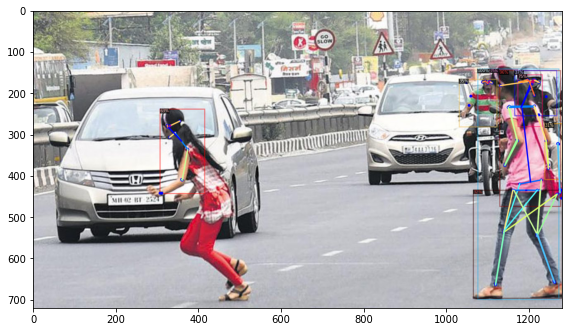

In [231]:
start_time = timeit.default_timer()

# prepare detectors
## initialize OD detector
predictor_od, cfg_od = __init__(mode="OD")

## initialize KP detector
predictor_kp, cfg_kp = __init__(mode="KP")

# 0. load an image
imagePath = "images/Pedestrian-Deaths-India-Road-Fatalities-India-1280x720.jpeg"
image = loadImage(imagePath=imagePath, changeColorMode=True)

# 1. perform detection and make prediction boxes
(
    predictions_od,
    reduced_predictions_od,
    prediction_od_boxes,
) = performDetection(
    predictor=predictor_od, image=image, classReduction=True
)
## make visualization part
viz_od = Visualizer(
    image[:, :, ::-1],
    metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]),
    instance_mode=ColorMode.IMAGE,
)
output_od = viz_od.draw_instance_predictions(reduced_predictions_od.to("cpu"))
image_with_boxes = output_od.get_image()[:, :, ::-1]

number_of_people = len(reduced_predictions_od)
predictions_kp_all = {}
images_kp_all = {}
image_final = image.copy()

for person_index in range(number_of_people):
    # 2. cut part of the image from bounding boxes
    image_cropped, cropped_image_coordinates = cropImageByBoundingBox(
        image=image, box=prediction_od_boxes[person_index]
    )

    # 3. make individual skeletonization for the cropped image
    ## perform detection
    predictions_kp = performDetection(
        predictor=predictor_kp, image=image_cropped, classReduction=False
    )
    ## make visualization part
    viz_kp = Visualizer(
        image_cropped[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
    )
    index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
    if index == 0:
        output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
    else:
        output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
    image_skeletonized = output_kp.get_image()[:, :, ::-1]

    # 4. project individual mask on the initial picture
    corrected_predictions = correctIndividualSkeletonCoordinates(
        initialPredictions=predictions_kp,
        image=image_cropped,
        croppedImageCoordinates=cropped_image_coordinates,
    )
    ## make visualization part
    viz_kp = Visualizer(
        image[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
    )
    if index == 0:
        output_kp = viz_kp.draw_instance_predictions(corrected_predictions.to("cpu"))
    else:
        output_kp = viz_kp.draw_instance_predictions(corrected_predictions[index].to("cpu"))
    image_skeletonized = output_kp.get_image()[:, :, ::-1]
    ## combine all results
    if index == 0:
      predictions_kp_all[person_index] = corrected_predictions.to("cpu")
    else:
      predictions_kp_all[person_index] = corrected_predictions[index].to("cpu")

    images_kp_all[person_index] = image_skeletonized

final_predictions = combineAllPredictionsTogether(predictionsDict=predictions_kp_all)
viz_kp = Visualizer(
        image[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
)
output_sum = viz_kp.draw_instance_predictions(final_predictions.to("cpu"))
image_sum = output_sum.get_image()[:, :, ::-1]

# 5. classify pedestrians
## import skeleton and classification data
new_column_names = pd.read_csv('skeleton_column_names.csv', header=None)[0].to_list()
new_labels = pd.read_csv('skeleton_labels.csv', header=None)[0].to_list()

df_skeleton = pd.read_csv('datasets/PedCut2013_SegmentationDataset/keypoints.json.udt.csv')
df_skeleton = df_skeleton[new_labels]
df_skeleton.columns = new_column_names
df_skeleton.dropna(inplace=True)

df_classification = pd.read_csv('datasets/PedCut2013_SegmentationDataset/classification.json.udt.csv')
df_classification = df_classification[['imageUrl', 'annotation']]
df_classification.dropna(inplace=True)
df_classification = pd.DataFrame(df_classification)
df_classification.columns = ['imageUrl', 'classification']

merged_df = df_skeleton.merge(df_classification, how = 'inner', on = ['imageUrl'])
new_column_names.pop(0)
df_skeleton = merged_df[new_column_names]

df_classification = merged_df['classification']
df_classification = pd.DataFrame(df_classification)

## initialize SVM model
C = 1
max_iter = 1000
epsilon = 0.0001
kernel_type = 'linear'
model = SVM(max_iter,kernel_type,C,epsilon)

## perform person classification
for person_index in range(number_of_people):
    df = addPedestrianDataToDataFrame(predictions=predictions_kp, index=0, classification="in motion")
    vector = np.array(df)[0][:34]

    person_classification = classifyPerson(df_classification, df_skeleton, model, vector)
    print("Person ", person_index, ': ', person_classification)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_sum)
plt.tight_layout()

stop_time = timeit.default_timer()
time_execution_difference = stop_time - start_time
print("Execution time was:", time_execution_difference, " s")

# experiment: detect people all by once, classify them and measure time

/Users/michal/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


Person  0 :  ['go-left', 'go-forward']
Person  1 :  ['go-left', 'go-forward', 'go-backward']
Person  2 :  ['go-left', 'go-forward', 'go-backward']
Person  3 :  ['go-left', 'go-forward', 'go-backward']
Person  4 :  ['go-left', 'go-forward', 'go-backward']
Person  5 :  ['go-left', 'go-forward', 'go-backward']
Person  6 :  ['go-left', 'go-forward', 'go-backward']
Execution time was: 32.732095791987376  s


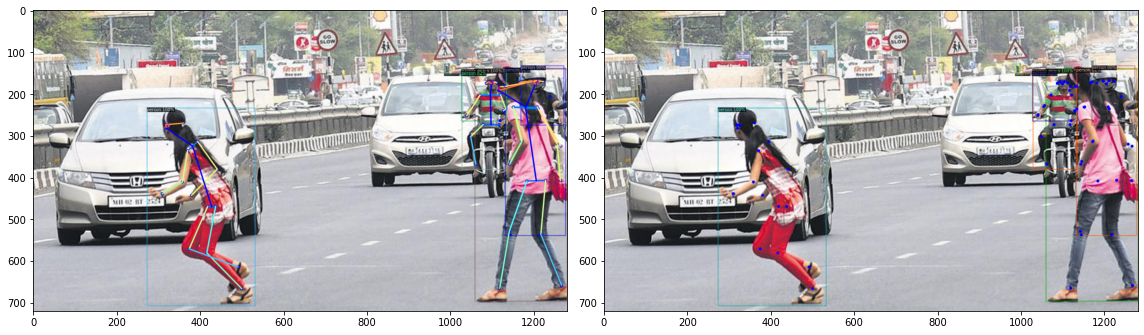

In [232]:
## start measuring execution time
start_time = timeit.default_timer()

## initialize KP detector
predictor_kp, cfg_kp = __init__(mode="KP")

## make predictions
predictions_kp = performDetection(predictor=predictor_kp, image=image, classReduction=False)

## make visualization part
viz_kp = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
viz_kp_dots = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
output_kp_dots = viz_kp_dots.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
image_final = output_kp.get_image()[:, :, ::-1]
image_final_dots = output_kp_dots.get_image()[:, :, ::-1]

# 5. classify pedestrians
## import skeleton and classification data
new_column_names = pd.read_csv('skeleton_column_names.csv', header=None)[0].to_list()
new_labels = pd.read_csv('skeleton_labels.csv', header=None)[0].to_list()

df_skeleton = pd.read_csv('datasets/PedCut2013_SegmentationDataset/keypoints.json.udt.csv')
df_skeleton = df_skeleton[new_labels]
df_skeleton.columns = new_column_names
df_skeleton.dropna(inplace=True)

df_classification = pd.read_csv('datasets/PedCut2013_SegmentationDataset/classification.json.udt.csv')
df_classification = df_classification[['imageUrl', 'annotation']]
df_classification.dropna(inplace=True)
df_classification = pd.DataFrame(df_classification)
df_classification.columns = ['imageUrl', 'classification']

merged_df = df_skeleton.merge(df_classification, how = 'inner', on = ['imageUrl'])
new_column_names.pop(0)
df_skeleton = merged_df[new_column_names]

df_classification = merged_df['classification']
df_classification = pd.DataFrame(df_classification)

## initialize SVM model
C = 1
max_iter = 1000
epsilon = 0.0001
kernel_type = 'linear'
model = SVM(max_iter,kernel_type,C,epsilon)

## perform person classification
number_of_people = len(predictions_kp["instances"])
for person_index in range(number_of_people):
    df = addPedestrianDataToDataFrame(predictions=predictions_kp, index=0, classification="in motion")
    vector = np.array(df)[0][:34]

    person_classification = classifyPerson(df_classification, df_skeleton, model, vector)
    print("Person ", person_index, ': ', person_classification)

## show resulsts
fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].imshow(image_final)
ax[1].imshow(image_final_dots)
plt.tight_layout()

## stop measuring execution time
stop_time = timeit.default_timer()
time_execution_difference = stop_time - start_time
print("Execution time was:", time_execution_difference, " s")

# 6. calculate SVM statistics

### False Positive Rate, False Negative Rate

In [233]:
# more info: https://github.com/sepandhaghighi/pycm
from pycm import *

In [266]:
new_column_names = pd.read_csv('skeleton_column_names.csv', header=None)[0].to_list()
new_labels = pd.read_csv('skeleton_labels.csv', header=None)[0].to_list()

df_skeleton = pd.read_csv('datasets/PedCut2013_SegmentationDataset/keypoints.json.udt.csv')
df_skeleton = df_skeleton[new_labels]
df_skeleton.columns = new_column_names
df_skeleton.dropna(inplace=True)

df_classification = pd.read_csv('datasets/PedCut2013_SegmentationDataset/classification.json.udt.csv')
df_classification = df_classification[['imageUrl', 'annotation']]
df_classification.dropna(inplace=True)
df_classification = pd.DataFrame(df_classification)
df_classification.columns = ['imageUrl', 'classification']

merged_df = df_skeleton.merge(df_classification, how = 'inner', on = ['imageUrl'])
new_column_names.pop(0)
df_skeleton = merged_df[new_column_names]

df_classification = merged_df['classification']
df_classification = pd.DataFrame(df_classification)

### Stats for --- Stationary (1) or In-motion (-1)

In [235]:
df_classification['simplified_classification'] = np.where(df_classification['classification'] == 'stationary', 1, -1)
y_actual = np.array(df_classification['simplified_classification'])

In [236]:
ncut = int(len(y_actual)*0.8)

y_actual_train = y_actual[:ncut]
y_actual_test = y_actual[ncut:]

x_train = df_skeleton[:ncut]
x_test = df_skeleton[ncut:]

In [237]:
C = 1
max_iter = 1000
epsilon = 0.0001
kernel_type = 'linear'
model = SVM(max_iter,kernel_type,C,epsilon)

X = np.array(x_train)
Y = np.array(y_actual_train)

model.performFit(X,Y)

In [238]:
y_pred = []

for _, row in x_test.iterrows():
    vector = np.array([])
    for col_name in new_column_names:
        skeleton_value = row[col_name]
        vector = np.append(vector, skeleton_value)
    person_classification = int(model.makePrediction(vector))
    y_pred.append(person_classification)

In [239]:
cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)

In [240]:
name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
cm_stats = cm_stats.T
cm_stats = cm_stats[['FP', 'FN']]
cm_stats = cm_stats.T
cm_stats

,In-motion,Stationary
Class,,
FP,30,0
FN,0,30


In [241]:
cm_stats.loc['FP']['In-motion']

'30'

In [242]:
cm_stats.tail(11)

,In-motion,Stationary
Class,,
FP,30,0
FN,0,30


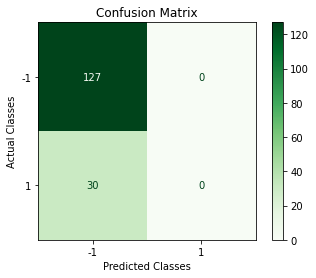

In [243]:
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib");

In [56]:
column_names = ["c", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for c in np.arange(0.2, 1.9, 0.1):
    C = c
    max_iter = 1000
    epsilon = 0.0001
    kernel_type = 'linear'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"c": c, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("c")

In [57]:
df_1 = df.copy()
df_1

,Stationary FP,Stationary FN,In-motion FP,In-motion FN
c,,,,
0.2,1.59,29.18,29.18,1.59
0.3,1.02,29.41,29.41,1.02
0.4,0.98,29.41,29.41,0.98
0.5,0.91,29.40,29.40,0.91
0.6,0.89,29.40,29.40,0.89
0.7,0.87,29.29,29.29,0.87
0.8,1.01,29.42,29.42,1.01
0.9,1.03,29.39,29.39,1.03
1.0,0.89,29.35,29.35,0.89


In [58]:
column_names = ["c", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for c in np.arange(0.2, 1.9, 0.1):
    C = c
    max_iter = 1000
    epsilon = 0.0001
    kernel_type = 'quadratic'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"c": c, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("c")

In [59]:
df_2= df.copy()
df_2

,Stationary FP,Stationary FN,In-motion FP,In-motion FN
c,,,,
0.2,1.08,29.28,29.28,1.08
0.3,0.81,29.24,29.24,0.81
0.4,0.71,29.20,29.20,0.71
0.5,0.78,29.18,29.18,0.78
0.6,0.55,29.11,29.11,0.55
0.7,0.65,29.18,29.18,0.65
0.8,0.38,28.99,28.99,0.38
0.9,0.53,29.13,29.13,0.53
1.0,0.57,29.07,29.07,0.57


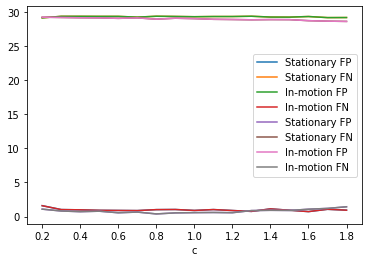

In [60]:
ax = df_1.plot()
df_2.plot(ax=ax)
ax.set_xticks(np.arange(0.2, 1.9, 0.2));

In [244]:
column_names = ["Max iter", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [100, 1000, 10000]:
    C = 1
    max_iter = mi
    epsilon = 0.0001
    kernel_type = 'linear'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Max iter": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Max iter")

df_3 = df.copy()
df_3

,Stationary FP,Stationary FN,In-motion FP,In-motion FN
Max iter,,,,
100.0,0.88,29.47,29.47,0.88
1000.0,0.84,29.45,29.45,0.84
10000.0,0.92,29.45,29.45,0.92


In [245]:
column_names = ["Max iter", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [100, 1000, 10000]:
    C = 1
    max_iter = mi
    epsilon = 0.0001
    kernel_type = 'quadratic'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Max iter": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Max iter")

df_4 = df.copy()
df_4

,Stationary FP,Stationary FN,In-motion FP,In-motion FN
Max iter,,,,
100.0,0.54,29.05,29.05,0.54
1000.0,0.53,29.11,29.11,0.53
10000.0,0.65,29.10,29.10,0.65


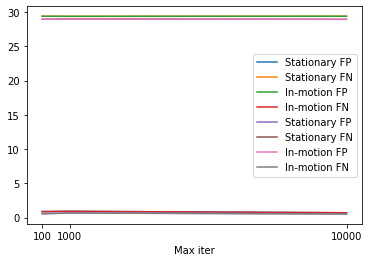

In [63]:
ax = df_3.plot()
df_4.plot(ax=ax)
ax.set_xticks([100, 1000, 10000]);

In [64]:
column_names = ["Epsilon", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [0.1, 0.01, 0.001, 0.0001, 0.0001, 0.00001, 0.00001]:
    C = 1
    max_iter = 1000
    epsilon = mi
    kernel_type = 'linear'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Epsilon": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Epsilon")

df_5 = df.copy()
df_5

,Stationary FP,Stationary FN,In-motion FP,In-motion FN
Epsilon,,,,
0.10000,0.82,29.39,29.39,0.82
0.01000,0.76,29.29,29.29,0.76
0.00100,0.84,29.51,29.51,0.84
0.00010,0.69,29.46,29.46,0.69
0.00010,1.02,29.26,29.26,1.02
0.00001,0.82,29.35,29.35,0.82
0.00001,0.95,29.30,29.30,0.95


In [65]:
column_names = ["Epsilon", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [0.1, 0.01, 0.001, 0.0001, 0.0001, 0.00001, 0.00001]:
    C = 1
    max_iter = 1000
    epsilon = mi
    kernel_type = 'quadratic'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Epsilon": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Epsilon")

df_5 = df.copy()
df_5

,Stationary FP,Stationary FN,In-motion FP,In-motion FN
Epsilon,,,,
0.10000,0.49,29.03,29.03,0.49
0.01000,0.55,29.14,29.14,0.55
0.00100,0.60,29.00,29.00,0.60
0.00010,0.55,29.14,29.14,0.55
0.00010,0.64,29.01,29.01,0.64
0.00001,0.66,29.12,29.12,0.66
0.00001,0.70,29.16,29.16,0.70


### Stats for --- Stationary (0), Go-forward (1), Go-right (2), Go-backward (3), Go-left (4)

In [277]:
df_classification['simplified_classification'] = np.where(df_classification['classification'] == 'stationary', 0,\
    np.where(df_classification['classification'] == 'go-forward', 1,\
    np.where(df_classification['classification'] == 'go-right', 2,\
    np.where(df_classification['classification'] == 'go-backward', 3,\
    np.where(df_classification['classification'] == 'go-left', 4, np.nan)))))

y_actual = np.array(df_classification['simplified_classification'])

In [294]:
ncut = int(len(y_actual)*0.8)

y_actual_train = y_actual[:ncut]
y_actual_test = y_actual[ncut:]

In [269]:
C = 1
max_iter = 1000
epsilon = 0.0001
kernel_type = 'linear'
model = SVM(max_iter,kernel_type,C,epsilon)

personClassification = classifyPerson(df_classification, df_skeleton, model, vector)

In [270]:
personClassification

['go-left', 'go-backward']

In [271]:
classification = ['go-backward', 'go-left', 'go-forward', 'go-right']
def simplifyClassification(classification):
    if 'go-left' in classification and 'go-right' not in classification:
        print('go-left')
        return 4.0
    elif 'go-left' not in classification and 'go-right' in classification:
        print('go-right')
        return 2.0
    elif 'go-forward' in classification and 'go-backward' not in classification:
        print('go-forward')
        return 1.0
    elif 'go-forward' not in classification and 'go-backward' in classification:
        print('go-backward')
        return 3.0
    else:
        print('stationary')
        return 0.0
simplifyClassification(classification)

stationary


0.0

In [272]:
y_pred = []

for _, row in x_test.iterrows():
    start_time = timeit.default_timer()
    vector = np.array([])
    for col_name in new_column_names:
        skeleton_value = row[col_name]
        vector = np.append(vector, skeleton_value)
    person_classification = simplifyClassification(classifyPerson(df_classification, df_skeleton, model, vector))
    y_pred.append(person_classification)
    stop_time = timeit.default_timer()
    time_execution_difference = stop_time - start_time
    print("Execution time was:", time_execution_difference, " s")

go-right
Execution time was: 2.4828393339994363  s
go-forward
Execution time was: 2.839983209007187  s
go-right
Execution time was: 2.642507041004137  s
go-right
Execution time was: 2.641603291995125  s
go-right
Execution time was: 2.7800323749979725  s
go-right
Execution time was: 3.186079749997589  s
go-left
Execution time was: 3.088678375002928  s
go-right
Execution time was: 2.400723749989993  s
go-right
Execution time was: 2.854813749989262  s
go-right
Execution time was: 2.2493687079986557  s
go-right
Execution time was: 2.3155486659961753  s
go-left
Execution time was: 2.802237915995647  s
go-left
Execution time was: 3.155855374992825  s
go-backward
Execution time was: 2.871283875007066  s
go-left
Execution time was: 2.8170422920084093  s
go-right
Execution time was: 2.8484610000014072  s
go-right
Execution time was: 3.153255875004106  s
go-backward
Execution time was: 2.6001647079974646  s
go-backward
Execution time was: 2.5100134999956936  s
go-backward
Execution time was: 2.5

In [296]:
len(y_actual_test)

157

In [298]:
cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)

In [299]:
name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'0.0': 'Stationary', '1.0': 'Go-forward', '2.0': 'Go-right', '3.0': 'Go-backward', '4.0': 'Go-left'})
cm_stats = cm_stats.T
cm_stats = cm_stats[['FP', 'FN']]
cm_stats = cm_stats.T
cm_stats

,Stationary,Go-forward,Go-right,Go-backward,Go-left
Class,,,,,
FP,0,5,30,7,28
FN,30,10,6,21,3


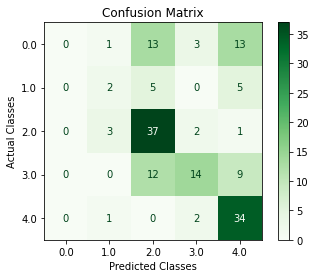

In [300]:
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib");

In [ ]:
column_names = ["c", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for c in np.arange(0.2, 1.9, 0.1):
    C = c
    max_iter = 1000
    epsilon = 0.0001
    kernel_type = 'linear'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"c": c, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("c")

In [ ]:
df_1 = df.copy()
df_1

,Stationary FP,Stationary FN,In-motion FP,In-motion FN
c,,,,
0.2,1.59,29.18,29.18,1.59
0.3,1.02,29.41,29.41,1.02
0.4,0.98,29.41,29.41,0.98
0.5,0.91,29.40,29.40,0.91
0.6,0.89,29.40,29.40,0.89
0.7,0.87,29.29,29.29,0.87
0.8,1.01,29.42,29.42,1.01
0.9,1.03,29.39,29.39,1.03
1.0,0.89,29.35,29.35,0.89


In [ ]:
column_names = ["c", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for c in np.arange(0.2, 1.9, 0.1):
    C = c
    max_iter = 1000
    epsilon = 0.0001
    kernel_type = 'quadratic'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"c": c, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("c")

In [ ]:
df_2= df.copy()
df_2

,Stationary FP,Stationary FN,In-motion FP,In-motion FN
c,,,,
0.2,1.08,29.28,29.28,1.08
0.3,0.81,29.24,29.24,0.81
0.4,0.71,29.20,29.20,0.71
0.5,0.78,29.18,29.18,0.78
0.6,0.55,29.11,29.11,0.55
0.7,0.65,29.18,29.18,0.65
0.8,0.38,28.99,28.99,0.38
0.9,0.53,29.13,29.13,0.53
1.0,0.57,29.07,29.07,0.57


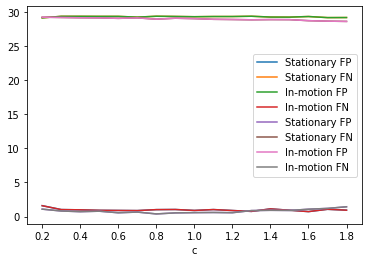

In [ ]:
ax = df_1.plot()
df_2.plot(ax=ax)
ax.set_xticks(np.arange(0.2, 1.9, 0.2));

In [ ]:
column_names = ["Max iter", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [100, 1000, 10000]:
    C = 1
    max_iter = mi
    epsilon = 0.0001
    kernel_type = 'linear'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Max iter": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Max iter")

df_3 = df.copy()
df_3

,Stationary FP,Stationary FN,In-motion FP,In-motion FN
Max iter,,,,
100.0,0.87,29.41,29.41,0.87
1000.0,0.91,29.40,29.40,0.91
10000.0,0.70,29.41,29.41,0.70


In [ ]:
column_names = ["Max iter", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [100, 1000, 10000]:
    C = 1
    max_iter = mi
    epsilon = 0.0001
    kernel_type = 'quadratic'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Max iter": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Max iter")

df_4 = df.copy()
df_4

,Stationary FP,Stationary FN,In-motion FP,In-motion FN
Max iter,,,,
100.0,0.56,28.97,28.97,0.56
1000.0,0.66,29.02,29.02,0.66
10000.0,0.53,28.96,28.96,0.53


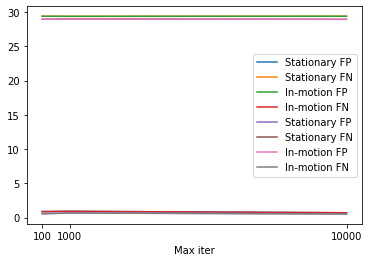

In [ ]:
ax = df_3.plot()
df_4.plot(ax=ax)
ax.set_xticks([100, 1000, 10000]);

In [ ]:
column_names = ["Epsilon", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [0.1, 0.01, 0.001, 0.0001, 0.0001, 0.00001, 0.00001]:
    C = 1
    max_iter = 1000
    epsilon = mi
    kernel_type = 'linear'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Epsilon": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Epsilon")

df_5 = df.copy()
df_5

,Stationary FP,Stationary FN,In-motion FP,In-motion FN
Epsilon,,,,
0.10000,0.82,29.39,29.39,0.82
0.01000,0.76,29.29,29.29,0.76
0.00100,0.84,29.51,29.51,0.84
0.00010,0.69,29.46,29.46,0.69
0.00010,1.02,29.26,29.26,1.02
0.00001,0.82,29.35,29.35,0.82
0.00001,0.95,29.30,29.30,0.95


In [ ]:
column_names = ["Epsilon", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [0.1, 0.01, 0.001, 0.0001, 0.0001, 0.00001, 0.00001]:
    C = 1
    max_iter = 1000
    epsilon = mi
    kernel_type = 'quadratic'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Epsilon": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Epsilon")

df_5 = df.copy()
df_5

,Stationary FP,Stationary FN,In-motion FP,In-motion FN
Epsilon,,,,
0.10000,0.49,29.03,29.03,0.49
0.01000,0.55,29.14,29.14,0.55
0.00100,0.60,29.00,29.00,0.60
0.00010,0.55,29.14,29.14,0.55
0.00010,0.64,29.01,29.01,0.64
0.00001,0.66,29.12,29.12,0.66
0.00001,0.70,29.16,29.16,0.70
